In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
train_df = pd.read_csv('clean_data.csv')
val_df = pd.read_csv('clean_val.csv')
test_df = pd.read_csv('clean_test.csv')

In [3]:
train_df.dropna(inplace = True)

In [4]:
with open("numerical.txt", "r", encoding="utf-8") as file:
    numeric_features = [line.strip() for line in file.readlines()]
    
with open("cat.txt", "r", encoding="utf-8") as file:
    cat_features = [line.strip() for line in file.readlines()]


In [5]:
print('Total number of Numerical Features and one target:', len(numeric_features))
print('Total number of Categorical Features:',len(cat_features))

Total number of Numerical Features and one target: 9
Total number of Categorical Features: 70


# Load Machine Learning Library

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lambdas_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for column in X.columns:
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            _, lambda_optimal = stats.boxcox(X[column])
            self.lambdas_[column] = lambda_optimal
        return self

    def transform(self, X):
        X = X.copy()
        for column, lambda_optimal in self.lambdas_.items():
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            X[column] = stats.boxcox(X[column], lmbda=lambda_optimal)
        return X


In [8]:
lg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

rf = RandomForestRegressor()
xgb = XGBRegressor()
lgm = LGBMRegressor()
cat = CatBoostRegressor()

models = [('lg', lg), ('ridge', ridge), ('lasso', lasso), ('elastic', elastic), ('rf', rf), ('xgb', xgb), ('lgm', lgm),('cat', cat)]

In [9]:
train_X = train_df[numeric_features + cat_features]
train_y = train_df['price']

val_X = val_df[numeric_features + cat_features]
val_y = val_df['price']

test_X = test_df[numeric_features + cat_features]
test_y = test_df['price']


In [13]:
def preprocessor_function(df):
   
    numeric_features = [col for col in df.columns[:9] if col in df.columns]
    cat_features = [col for col in df.columns[9:-5] if col in df.columns]
    
    numeric_transformer = Pipeline([
        ('boxcox', BoxCoxTransformer()),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    return preprocessor

In [15]:
from tqdm import tqdm

def rmse(y, y_predict):
    mse = mean_squared_error(y, y_predict)
    return math.sqrt(mse)

def evaluate_models(model):
    results = []

    for name, model in tqdm(model, desc="Evaluating Models"):
        pipeline = Pipeline([
            ('preprocessor', preprocessor_function(train_df)),
            ('regression', model)
        ])
        
        pipeline.fit(train_X, train_y)
        
        val_predict = pipeline.predict(val_X)
        
        val_mae = mean_absolute_error(val_y, val_predict)
        val_rmse = rmse(val_y, val_predict)
        
        
        test_predict = pipeline.predict(test_X)
        test_mae = mean_absolute_error(test_y, test_predict)
        test_rmse = rmse(test_y, test_predict)
       
        results.append({
            'model': name,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
        })
    
    return results

# Evalute Result

In [16]:
res = evaluate_models(models)

Evaluating Models:  75%|████████████████████████████████████████████████                | 6/8 [08:38<04:04, 122.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 17941, number of used features: 302
[LightGBM] [Info] Start training from score 134.868792


Evaluating Models:  88%|████████████████████████████████████████████████████████▉        | 7/8 [08:39<01:22, 82.73s/it]

Learning rate set to 0.064608
0:	learn: 99.0332913	total: 178ms	remaining: 2m 57s
1:	learn: 96.4810982	total: 188ms	remaining: 1m 33s
2:	learn: 94.1693781	total: 197ms	remaining: 1m 5s
3:	learn: 92.0574061	total: 206ms	remaining: 51.3s
4:	learn: 90.3081270	total: 215ms	remaining: 42.8s
5:	learn: 88.5195452	total: 224ms	remaining: 37.1s
6:	learn: 86.9758231	total: 233ms	remaining: 33s
7:	learn: 85.6218836	total: 264ms	remaining: 32.8s
8:	learn: 84.2632248	total: 273ms	remaining: 30s
9:	learn: 83.0512368	total: 281ms	remaining: 27.9s
10:	learn: 81.9781469	total: 291ms	remaining: 26.1s
11:	learn: 81.0236835	total: 299ms	remaining: 24.7s
12:	learn: 80.1803127	total: 308ms	remaining: 23.4s
13:	learn: 79.3880886	total: 317ms	remaining: 22.4s
14:	learn: 78.6621519	total: 326ms	remaining: 21.4s
15:	learn: 78.0584278	total: 335ms	remaining: 20.6s
16:	learn: 77.4389586	total: 344ms	remaining: 19.9s
17:	learn: 76.9101017	total: 353ms	remaining: 19.3s
18:	learn: 76.3761382	total: 362ms	remaining: 

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 8/8 [08:51<00:00, 66.38s/it]


In [17]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
7,cat,48.923889,274.947126,45.435616,135.675032
5,xgb,49.376936,275.069624,45.575750,133.513682
6,lgm,49.372014,274.327459,45.701704,137.234545
4,rf,50.023629,275.698355,46.048168,139.548958
1,ridge,60.019968,281.377948,55.852781,150.701109
0,lg,60.393103,281.495912,56.002050,150.388048
2,lasso,60.701732,282.314485,56.833592,153.526881
3,elastic,62.645983,283.375987,58.135126,156.171288


# Fine Tunning using Optuna

In [18]:
import optuna

def objective(trial):

    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.05)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 200, 1000)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 5.0, 15.0)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    boosting_type = trial.suggest_categorical('boosting_type', ['Plain', 'Ordered'])
    
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        colsample_bylevel=colsample_bylevel,
        boosting_type=boosting_type,
        random_state=42,
        logging_level='Silent'
    )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor_function(train_df)),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [19]:
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective, n_trials=50) 

[I 2024-11-09 13:56:57,965] A new study created in memory with name: no-name-ad5a779a-65a9-4114-b5a1-150dbecdee13
[I 2024-11-09 13:57:05,111] Trial 0 finished with value: 50.45452623677324 and parameters: {'learning_rate': 0.04651480650233602, 'max_depth': 7, 'n_estimators': 517, 'l2_leaf_reg': 10.554767817214238, 'subsample': 0.6630162998487517, 'colsample_bylevel': 0.6092702790211055, 'boosting_type': 'Plain'}. Best is trial 0 with value: 50.45452623677324.
[I 2024-11-09 13:57:09,050] Trial 1 finished with value: 54.46406331828658 and parameters: {'learning_rate': 0.011894772224633879, 'max_depth': 6, 'n_estimators': 344, 'l2_leaf_reg': 5.147867536953488, 'subsample': 0.8865403955990777, 'colsample_bylevel': 0.8672470284272807, 'boosting_type': 'Plain'}. Best is trial 0 with value: 50.45452623677324.
[I 2024-11-09 13:57:14,126] Trial 2 finished with value: 53.270964038885815 and parameters: {'learning_rate': 0.024017076369302566, 'max_depth': 8, 'n_estimators': 214, 'l2_leaf_reg': 11

In [20]:
cat_best_param = study1.best_trial.params
print("Best trial for CatBoostRegressor:")
print(study1.best_trial.params)
print("Best Validation MAE:", study1.best_value)

Best trial for CatBoostRegressor:
{'learning_rate': 0.0495918790401119, 'max_depth': 10, 'n_estimators': 949, 'l2_leaf_reg': 9.024899370884361, 'subsample': 0.6932031748326491, 'colsample_bylevel': 0.5907921664828304, 'boosting_type': 'Ordered'}
Best Validation MAE: 48.739331053465314


In [21]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = LGBMRegressor(
                learning_rate=learning_rate,
                max_depth=max_depth,
                n_estimators=n_estimators,
                num_leaves=num_leaves,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                verbosity=-1,
                random_state=42
            )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor_function(train_df)),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [22]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=50) 

[I 2024-11-09 15:31:30,290] A new study created in memory with name: no-name-568e43c9-8425-4c18-b57d-f803f0678c72
[I 2024-11-09 15:31:31,864] Trial 0 finished with value: 48.73077164084087 and parameters: {'learning_rate': 0.02640435189411311, 'max_depth': 8, 'n_estimators': 924, 'num_leaves': 28, 'subsample': 0.6343355311503122, 'colsample_bytree': 0.7423517973195259}. Best is trial 0 with value: 48.73077164084087.
[I 2024-11-09 15:31:32,543] Trial 1 finished with value: 54.59695533061196 and parameters: {'learning_rate': 0.018477040262224964, 'max_depth': 4, 'n_estimators': 176, 'num_leaves': 120, 'subsample': 0.6129438198753036, 'colsample_bytree': 0.900262288175651}. Best is trial 0 with value: 48.73077164084087.
[I 2024-11-09 15:31:33,864] Trial 2 finished with value: 49.44529058057498 and parameters: {'learning_rate': 0.023672297542414976, 'max_depth': 6, 'n_estimators': 699, 'num_leaves': 90, 'subsample': 0.8596295741852221, 'colsample_bytree': 0.9553340203349205}. Best is trial

In [23]:
lgbm_best_param = study2.best_trial.params
print("Best trial for LightBoostRegressor:")
print(study2.best_trial.params)
print("Best Validation MAE:", study2.best_value)

Best trial for LightBoostRegressor:
{'learning_rate': 0.029825459325340406, 'max_depth': 10, 'n_estimators': 938, 'num_leaves': 52, 'subsample': 0.8658289053526068, 'colsample_bytree': 0.6539801021880658}
Best Validation MAE: 48.072255945511564


In [24]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    alpha =  trial.suggest_loguniform('alpha', 1e-8, 10.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 1.0)
    
    model = XGBRegressor(
                learning_rate=learning_rate,
                max_depth=max_depth,
                n_estimators=n_estimators,
                subsample=subsample,
                alpha = alpha,
                colsample_bytree = colsample_bytree,
                random_state=42
            )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor_function(train_df)),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [25]:
study3 = optuna.create_study(direction='minimize')
study3.optimize(objective, n_trials=50) 

[I 2024-11-09 15:32:54,704] A new study created in memory with name: no-name-03d969a6-7f31-48d1-a392-ad13b7584bcf
[I 2024-11-09 15:32:58,264] Trial 0 finished with value: 52.90232876142561 and parameters: {'learning_rate': 0.012903695992242803, 'max_depth': 3, 'n_estimators': 720, 'subsample': 0.8981640485186624, 'alpha': 1.680321137682997e-08, 'colsample_bytree': 0.7954819172172742}. Best is trial 0 with value: 52.90232876142561.
[I 2024-11-09 15:32:59,687] Trial 1 finished with value: 54.71016490621029 and parameters: {'learning_rate': 0.021990139181053865, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6950922647731694, 'alpha': 0.5453243494595842, 'colsample_bytree': 0.7567270676445248}. Best is trial 0 with value: 52.90232876142561.
[I 2024-11-09 15:33:04,593] Trial 2 finished with value: 49.33847070918315 and parameters: {'learning_rate': 0.012598614707144767, 'max_depth': 6, 'n_estimators': 745, 'subsample': 0.8955582042187588, 'alpha': 0.001406335663704331, 'colsample_bytr

In [26]:
xgb_best_param = study3.best_trial.params
print("Best trial for XGBRegressor:")
print(study3.best_trial.params)
print("Best Validation MAE:", study3.best_value)

Best trial for XGBRegressor:
{'learning_rate': 0.024185175391235006, 'max_depth': 9, 'n_estimators': 994, 'subsample': 0.8358761213379997, 'alpha': 5.58689296951588, 'colsample_bytree': 0.4938107751384061}
Best Validation MAE: 47.21800192568987


In [27]:
best_xgb = XGBRegressor(**xgb_best_param)
best_lgm = LGBMRegressor(**lgbm_best_param)
best_cat = CatBoostRegressor(**cat_best_param)

best_models = [('cat', best_cat), ('lgm', best_lgm), ('xgb', best_xgb)]

In [28]:
res = evaluate_models(best_models)

Evaluating Models:   0%|                                                                         | 0/3 [00:00<?, ?it/s]

0:	learn: 99.6858066	total: 277ms	remaining: 4m 22s
1:	learn: 97.7304318	total: 606ms	remaining: 4m 46s
2:	learn: 95.9736837	total: 912ms	remaining: 4m 47s
3:	learn: 94.2612273	total: 1.06s	remaining: 4m 11s
4:	learn: 92.6107022	total: 1.33s	remaining: 4m 11s
5:	learn: 91.1608281	total: 1.42s	remaining: 3m 42s
6:	learn: 89.7964264	total: 1.72s	remaining: 3m 50s
7:	learn: 88.4424773	total: 2.02s	remaining: 3m 57s
8:	learn: 87.2576451	total: 2.3s	remaining: 4m
9:	learn: 86.2038561	total: 2.6s	remaining: 4m 3s
10:	learn: 85.1831801	total: 2.75s	remaining: 3m 54s
11:	learn: 84.2265729	total: 3.02s	remaining: 3m 55s
12:	learn: 83.2884176	total: 3.32s	remaining: 3m 58s
13:	learn: 82.4414559	total: 3.47s	remaining: 3m 51s
14:	learn: 81.7114420	total: 3.74s	remaining: 3m 53s
15:	learn: 80.9849149	total: 4.03s	remaining: 3m 55s
16:	learn: 80.2994713	total: 4.34s	remaining: 3m 57s
17:	learn: 79.6099545	total: 4.62s	remaining: 3m 58s
18:	learn: 78.9891569	total: 4.9s	remaining: 3m 59s
19:	learn: 

Evaluating Models:  33%|█████████████████████▎                                          | 1/3 [04:21<08:43, 261.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 17941, number of used features: 302
[LightGBM] [Info] Start training from score 134.868792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 3/3 [04:32<00:00, 90.74s/it]


In [29]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
2,xgb,47.422886,273.740739,44.368163,138.540895
1,lgm,48.562271,273.585016,44.489222,135.544691
0,cat,48.955835,275.083339,44.896785,136.166436


The best model, using only numerical and categorical features, is the fine-tuned XGB, which achieved a testing MAE of 44.36 and a testing RMSE of 138.54.

# Using XGB for feature importance

In [43]:

preprocessor = preprocessor_function(train_df)  
preprocessor.fit(train_X)

final_feature_names = get_feature_names_from_column_transformer(preprocessor)


model = XGBRegressor(**xgb_best_param)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', model)
])


pipeline.fit(train_X, train_y)

xgb_model = pipeline.named_steps['regression']

importances = xgb_model.feature_importances_


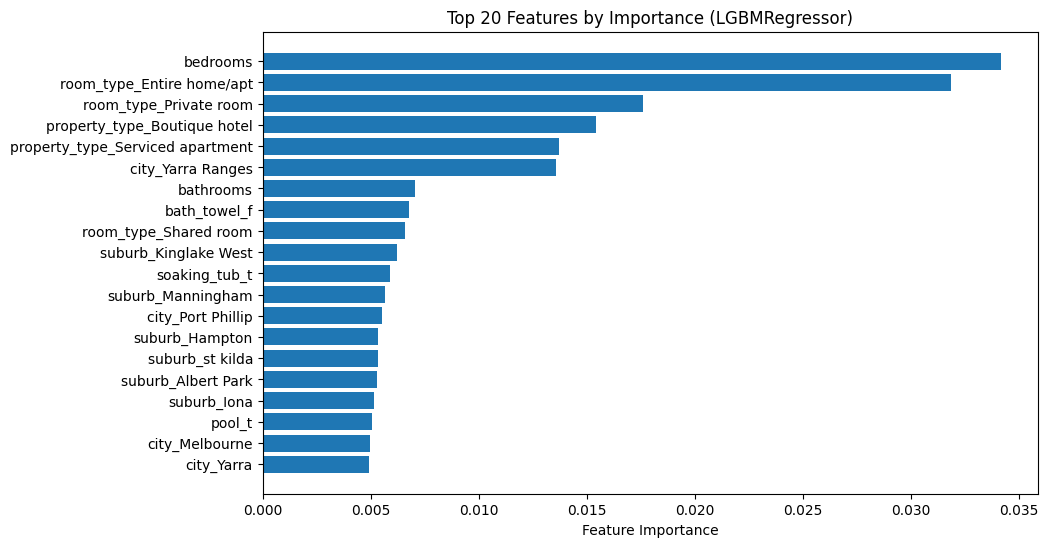

In [42]:
feature_importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Importance (LGBMRegressor)")
plt.show()